In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm


# from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
# from replay.experimental.scenarios.movielens_wrapper.MIPS import MIPS
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# import obp
# from obp.dataset import OpenBanditDataset
# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/15 14:49:47 WARN Utils: Your hostname, hdilab-hdilabALIEN05 resolves to a loopback address: 127.0.1.1; using 172.21.136.110 instead (on interface enp3s0)
24/09/15 14:49:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/15 14:49:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/15 14:49:48 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [5]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
dataset = MovielensBanditDataset(data)

15-Sep-24 14:49:54, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


15-Sep-24 14:50:00, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
15-Sep-24 14:50:01, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model
predict started


100%|██████████| 1000209/1000209 [02:42<00:00, 6136.49it/s]


In [7]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

100%|██████████| 111054/111054 [00:17<00:00, 6184.28it/s]


700144
111054


In [8]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [9]:
#Define replay model
model_1 = UCB(exploration_coef = 2.0, sample = True, seed = 123)
model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
model_3 = RandomRec(seed=42)

#Define learner which connects OBP data format with replay
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2) #len_list is the number of predicted items per user
learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [10]:
#Fit replay model inside our learner
learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
learner_3.fit(bandit_feedback_train)

In [11]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(dataset.n_actions,
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

# np.save('estimated_rewards_by_reg_model', estimated_rewards_by_reg_model)
estimated_rewards_by_reg_model = np.load('estimated_rewards_by_reg_model.npy')

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [12]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], dataset.n_actions, 1))
    if isinstance(learner.replay_model, (LinUCB)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            log_subset = log_distinct.iloc[i*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[i*batch_size:j] = action_dist
    return all_action_dist

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
#Predict distribution over actions: shape (n_rounds, n_actions)
import time
# start = time.time()
# learner_action_dist_1 = get_dist(learner_1)
# print(time.time() - start)

# np.save('learner_action_dist_1', learner_action_dist_1)
learner_action_dist_1 = np.load('learner_action_dist_1.npy')

# start = time.time()
# learner_action_dist_2 = get_dist(learner_2)
# print(time.time() - start)

# np.save('learner_action_dist_2', learner_action_dist_2)
learner_action_dist_2 = np.load('learner_action_dist_2.npy')

# start = time.time()
# learner_action_dist_3 = get_dist(learner_3)
# print(time.time() - start)

# np.save('learner_action_dist_3', learner_action_dist_3)
learner_action_dist_3 = np.load('learner_action_dist_3.npy')

100%|██████████| 371/371 [01:01<00:00,  5.99it/s]


62.01023817062378


100%|██████████| 112/112 [00:29<00:00,  3.82it/s]


29.39696717262268


100%|██████████| 371/371 [00:56<00:00,  6.61it/s]


56.153605937957764


In [15]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [5000, 10000, 15000, 20000, 25000, 30000]:
    # for n_size in [50000, 100000, 150000, 200000, 250000, 300000]:
    for n_size in [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :]
        
        action_dist = learner_action_dist[:n_size, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=10000,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [16]:
import os
os.path.getsize("/home/hdilab/sudakovcom/RePlayHDILab2024/replay/experimental/scenarios/movielens_wrapper/learner_action_dist_1.npy")/1024/1024/1024

3.2128594666719437

In [17]:
import os
os.path.getsize("/home/hdilab/sudakovcom/RePlayHDILab2024/replay/experimental/scenarios/movielens_wrapper/estimated_rewards_by_reg_model.npy")/1024/1024/1024

3.2128594666719437

In [18]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 10000 time:  5.798830509185791
n_size = 20000 time:  10.821213722229004
n_size = 30000 time:  8.946022748947144
n_size = 40000 time:  21.424672603607178
n_size = 50000 time:  18.49110174179077
n_size = 60000 time:  16.8215115070343
n_size = 70000 time:  41.79309892654419
n_size = 80000 time:  40.93037700653076
n_size = 90000 time:  39.70911526679993
n_size = 100000 time:  39.14699697494507
n_size = 111054 time:  38.22405385971069


In [23]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 10000 time:  5.776337146759033
n_size = 20000 time:  10.72953724861145
n_size = 30000 time:  8.711305141448975
n_size = 40000 time:  20.89384174346924
n_size = 50000 time:  18.525073051452637
n_size = 60000 time:  17.081193447113037
n_size = 70000 time:  42.16165804862976
n_size = 80000 time:  41.02434587478638
n_size = 90000 time:  39.03695344924927
n_size = 100000 time:  37.88178110122681
n_size = 111054 time:  39.37056255340576


In [25]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 10000 time:  5.942606687545776
n_size = 20000 time:  10.574946165084839
n_size = 30000 time:  8.67042851448059
n_size = 40000 time:  20.6994948387146
n_size = 50000 time:  18.27305579185486
n_size = 60000 time:  16.610467433929443
n_size = 70000 time:  41.834742069244385
n_size = 80000 time:  40.587895154953
n_size = 90000 time:  38.18705892562866
n_size = 100000 time:  36.53750801086426
n_size = 111054 time:  37.58771324157715


In [21]:
import matplotlib.pyplot as plt
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

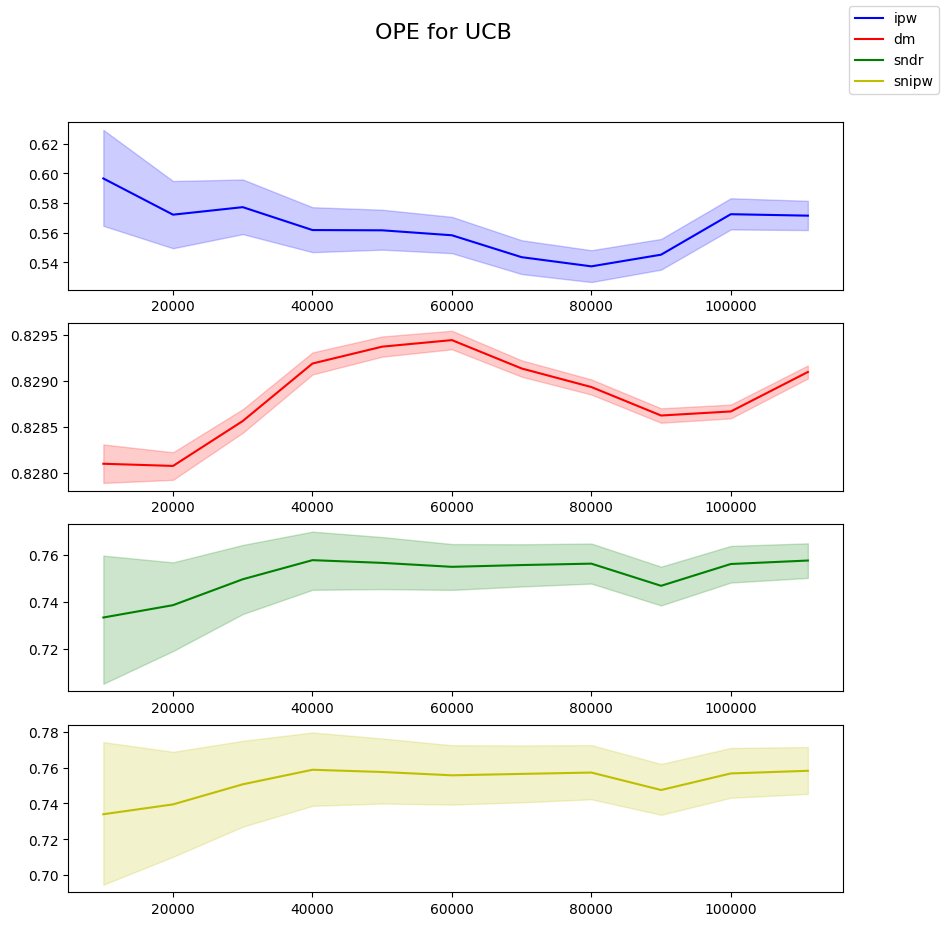

In [22]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

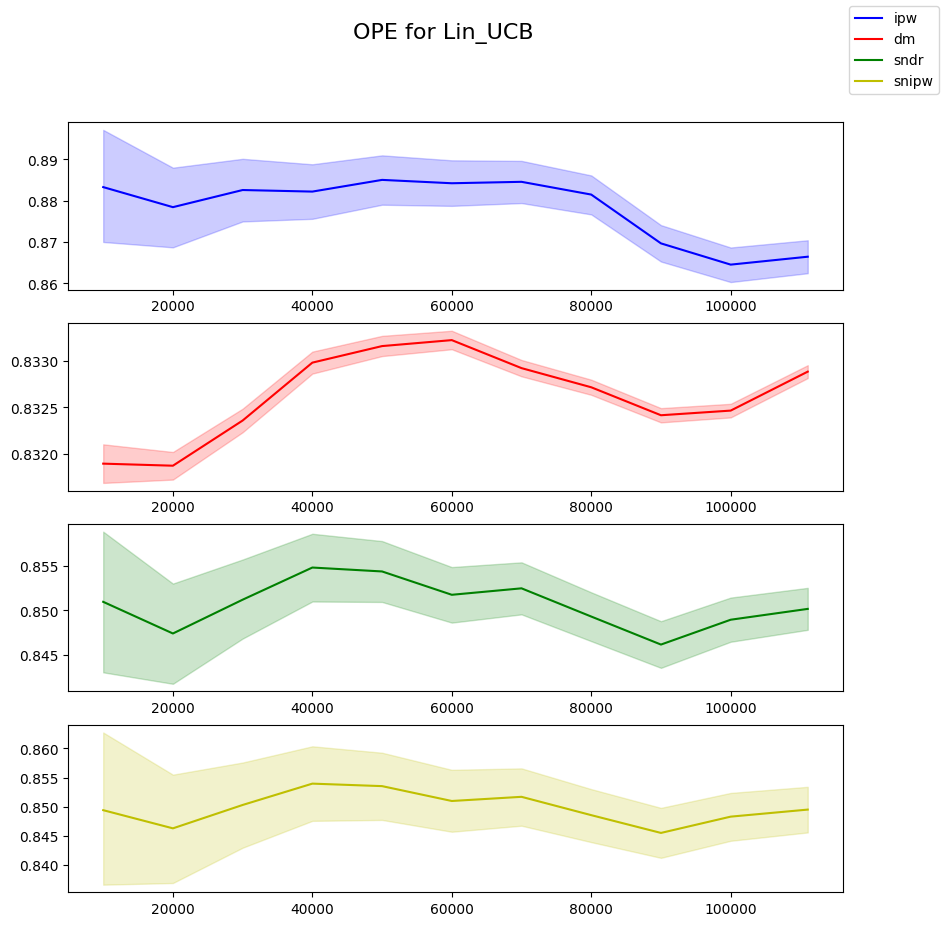

In [24]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

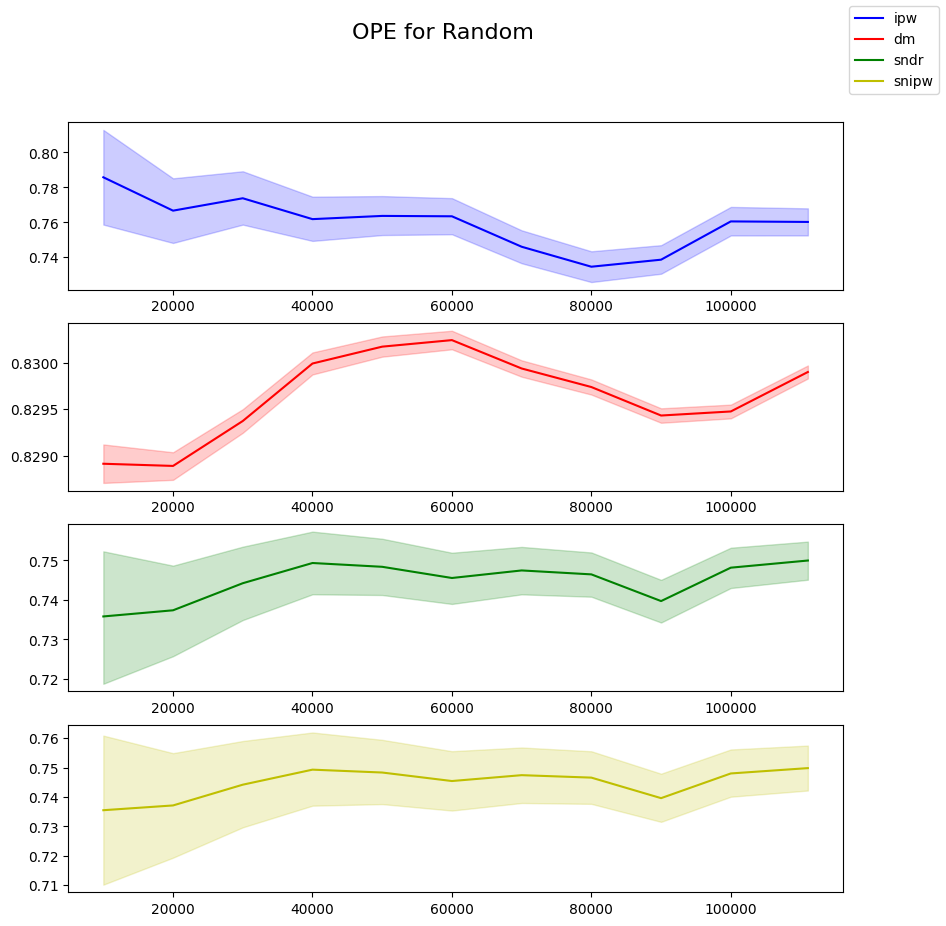

In [26]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [27]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 571.548, dm : 829.095, sndr : 757.724, snipw : 758.297


In [28]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 866.459, dm : 832.885, sndr : 850.182, snipw : 849.560


In [29]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 760.234, dm : 829.902, sndr : 749.971, snipw : 749.835


In [30]:
print("USB all")
print(Vs_1)

USB all
[{'ipw': 0.5966019498071081, 'dm': 0.8281009804634315, 'sndr': 0.7335435257910361, 'snipw': 0.7341096539065839}, {'ipw': 0.572100906018389, 'dm': 0.8280776213253379, 'sndr': 0.7387506352698857, 'snipw': 0.7394489956318313}, {'ipw': 0.5771858059527321, 'dm': 0.8285639145596152, 'sndr': 0.7497449225058922, 'snipw': 0.7506636040657426}, {'ipw': 0.5617985807778835, 'dm': 0.8291871516972115, 'sndr': 0.7579164720325015, 'snipw': 0.7588065521618914}, {'ipw': 0.561641980809579, 'dm': 0.8293693550504165, 'sndr': 0.7567270750529463, 'snipw': 0.7575805356228124}, {'ipw': 0.5582708142802849, 'dm': 0.8294399668576314, 'sndr': 0.7550140020864886, 'snipw': 0.7556920900964127}, {'ipw': 0.5435748477346406, 'dm': 0.8291333718256377, 'sndr': 0.7558064785224837, 'snipw': 0.7565302441769756}, {'ipw': 0.5374417759127534, 'dm': 0.8289324542756049, 'sndr': 0.7564046106301283, 'snipw': 0.7573395810786555}, {'ipw': 0.545282019645807, 'dm': 0.8286240716050323, 'sndr': 0.7469507036673905, 'snipw': 0.74759

In [31]:
print("Lin USB all")
print(Vs_2)

Lin USB all
[{'ipw': 0.8831444840742106, 'dm': 0.8318953634715164, 'sndr': 0.8509375019597449, 'snipw': 0.8493123936730123}, {'ipw': 0.8783594745758367, 'dm': 0.8318734735791357, 'sndr': 0.8473825110180032, 'snipw': 0.8462614733407663}, {'ipw': 0.8824969236530035, 'dm': 0.8323590288940061, 'sndr': 0.8511901797216901, 'snipw': 0.8502598598516866}, {'ipw': 0.8821931621316362, 'dm': 0.8329820043860294, 'sndr': 0.8548282775596193, 'snipw': 0.8539902923568289}, {'ipw': 0.8850488254716689, 'dm': 0.8331593244589858, 'sndr': 0.8543994798536078, 'snipw': 0.8535869208309844}, {'ipw': 0.8842220874110992, 'dm': 0.8332233266281113, 'sndr': 0.8517669027292325, 'snipw': 0.8510245822557178}, {'ipw': 0.8845982108530667, 'dm': 0.8329228902131827, 'sndr': 0.8525145978298176, 'snipw': 0.8517689141351954}, {'ipw': 0.8815023562854474, 'dm': 0.8327170336136347, 'sndr': 0.8493276756152525, 'snipw': 0.8486162720804896}, {'ipw': 0.8696844060951414, 'dm': 0.8324163547859411, 'sndr': 0.8461626685658046, 'snipw': 

In [32]:
print("Random all")
print(Vs_3)

Random all
[{'ipw': 0.7859086391357292, 'dm': 0.8289117117839574, 'sndr': 0.7358614032985956, 'snipw': 0.7355780635364922}, {'ipw': 0.7666721126650856, 'dm': 0.8288884316661893, 'sndr': 0.73736534096462, 'snipw': 0.7370948823215198}, {'ipw': 0.773806460478288, 'dm': 0.8293728422861496, 'sndr': 0.7442044323956643, 'snipw': 0.744192532017899}, {'ipw': 0.7618029224498468, 'dm': 0.8299936621236298, 'sndr': 0.7493673871875483, 'snipw': 0.7492750693864172}, {'ipw': 0.76366333367638, 'dm': 0.8301751437222179, 'sndr': 0.7483868534240548, 'snipw': 0.7483088979352029}, {'ipw': 0.7634239685609595, 'dm': 0.8302454672953695, 'sndr': 0.745526925402886, 'snipw': 0.7453919821881504}, {'ipw': 0.7460086815222104, 'dm': 0.8299400408608871, 'sndr': 0.7474740655402773, 'snipw': 0.7474185711681026}, {'ipw': 0.7345904429428772, 'dm': 0.8297398994784637, 'sndr': 0.7464696607355565, 'snipw': 0.7466078535585927}, {'ipw': 0.738610785776644, 'dm': 0.8294326818938599, 'sndr': 0.7396803505295821, 'snipw': 0.7396087

In [33]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())

Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw
mean              0.571459  0.829094  0.757720  0.758178
95.0% CI (lower)  0.561745  0.829024  0.750305  0.745291
95.0% CI (upper)  0.581443  0.829165  0.765049  0.771425
Estimated confidence intervals Lin UCB:
                       ipw        dm      sndr     snipw
mean              0.866424  0.832884  0.850167  0.849527
95.0% CI (lower)  0.862430  0.832815  0.847803  0.845610
95.0% CI (upper)  0.870403  0.832954  0.852541  0.853428
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.760199  0.829901  0.749983  0.749800
95.0% CI (lower)  0.752464  0.829831  0.745110  0.742171
95.0% CI (upper)  0.767984  0.829972  0.754783  0.757478


In [34]:
print(Vs_1[-1])
print(Vs_2[-1])
print(Vs_3[-1])

{'ipw': 0.5715481240415263, 'dm': 0.8290953295693756, 'sndr': 0.7577241114445916, 'snipw': 0.7582970282159053}
{'ipw': 0.866458626599945, 'dm': 0.8328851304362355, 'sndr': 0.8501819704060221, 'snipw': 0.8495601930911255}
{'ipw': 0.7602338042144501, 'dm': 0.8299021526201135, 'sndr': 0.7499709433271564, 'snipw': 0.7498346856523201}


In [35]:
def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
    fig, ax = plt.subplots(4, figsize=(15, 10))
    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i=0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

        ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

        ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
        ax[i].set_title(name)
        
        i = i+1
    fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
    fig.legend()

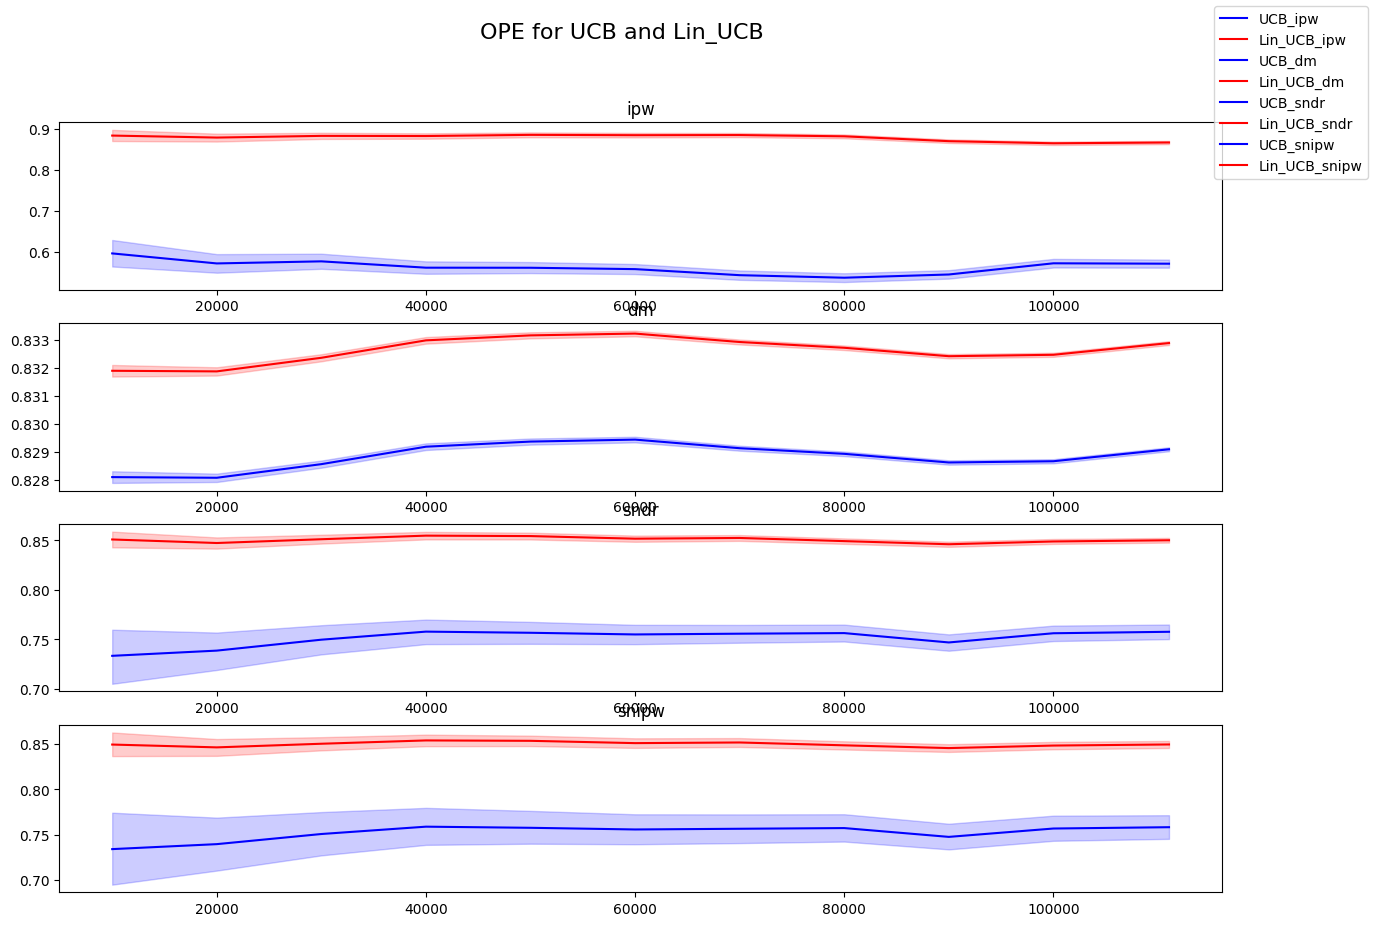

In [36]:
plot_res_two_politics(CIs_1, CIs_2, "UCB", "Lin_UCB")

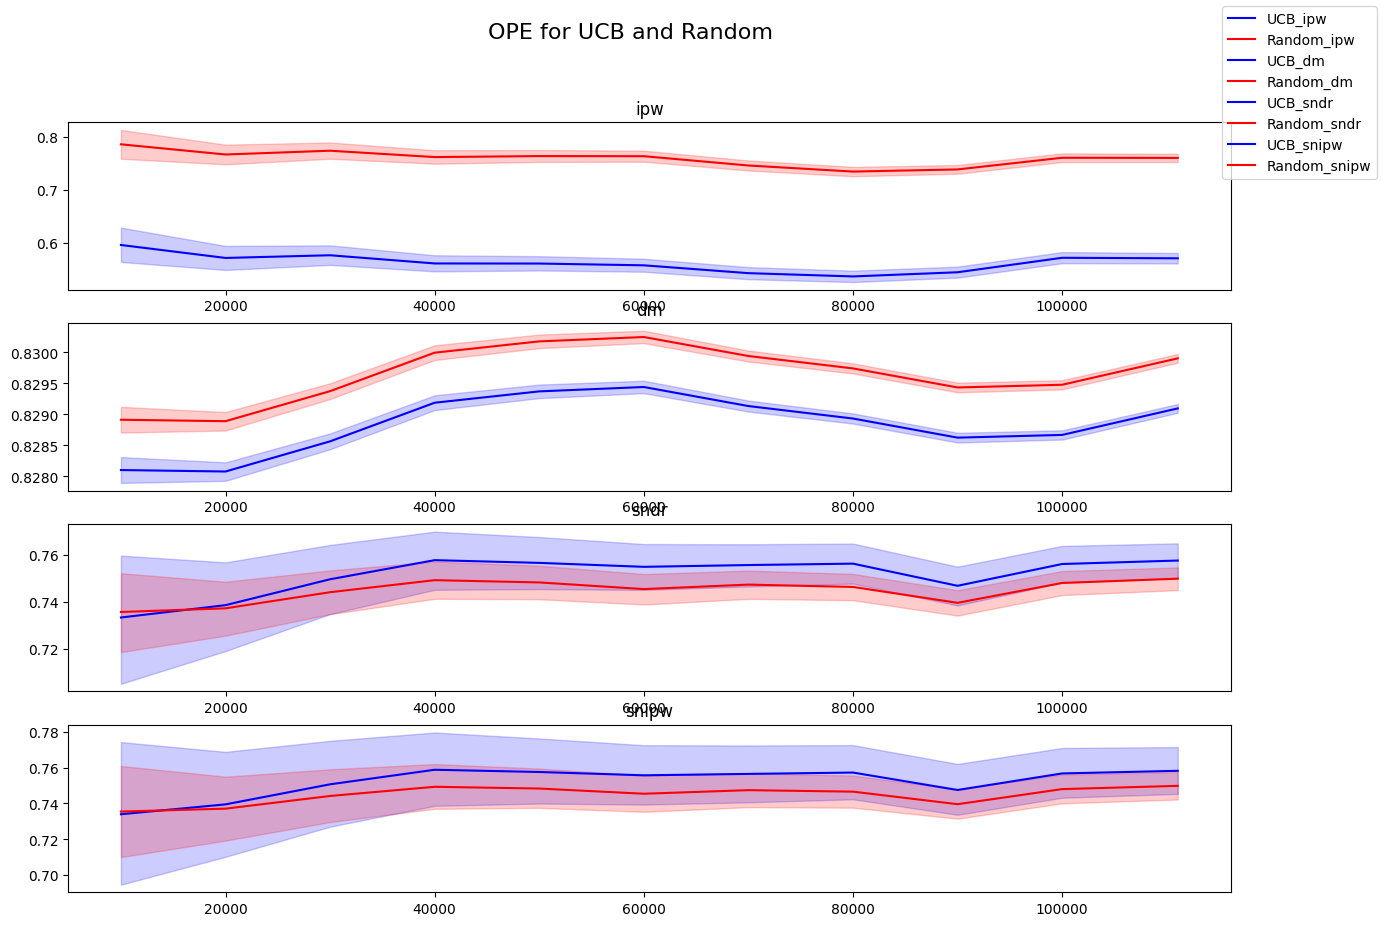

In [37]:
plot_res_two_politics(CIs_1, CIs_3, "UCB", "Random")

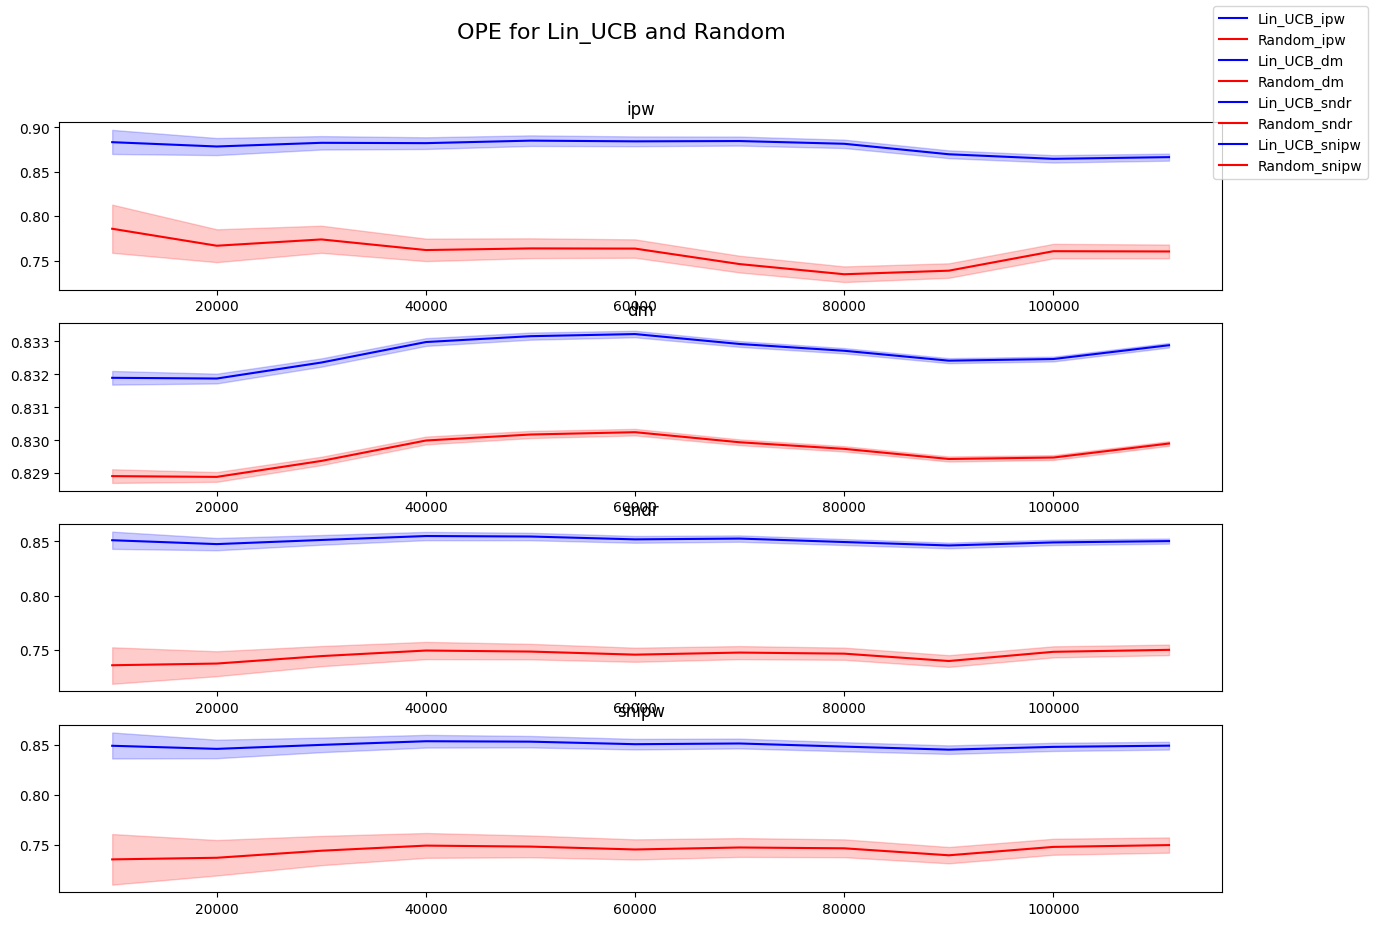

In [38]:
plot_res_two_politics(CIs_2, CIs_3, "Lin_UCB", "Random")

In [39]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw','dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

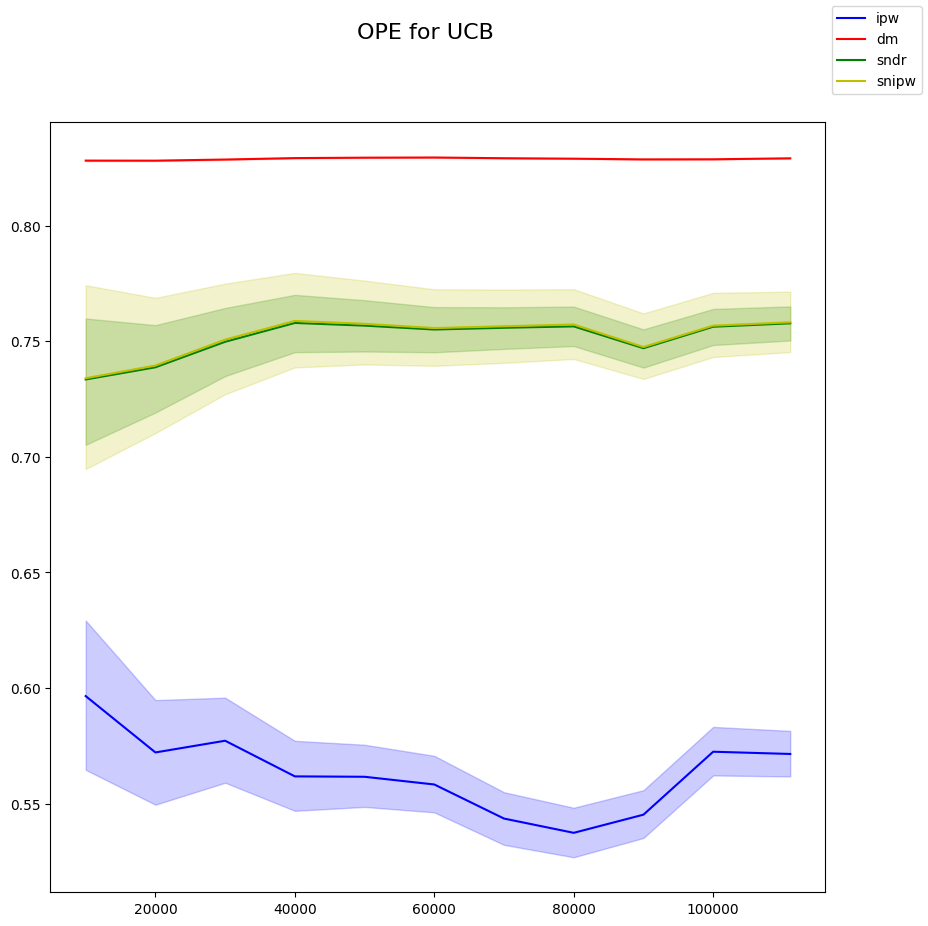

In [40]:
plot_join_res(Vs_1, CIs_1, 'UCB')

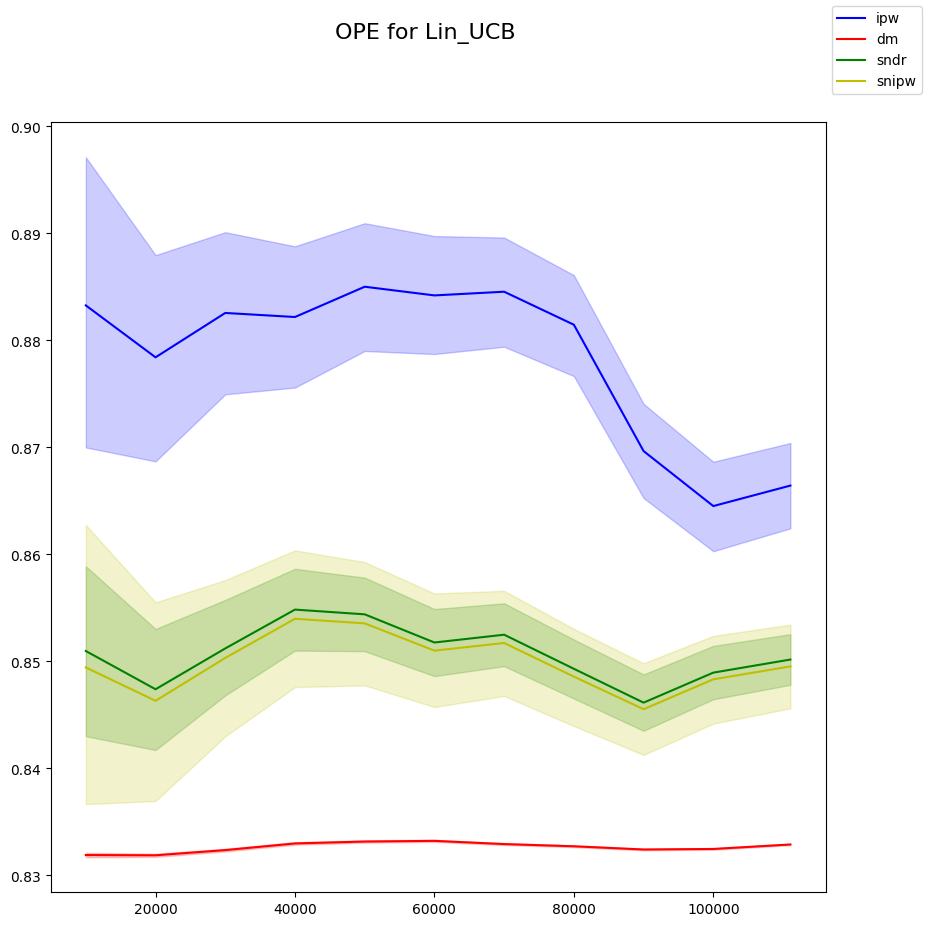

In [41]:
plot_join_res(Vs_2, CIs_2, 'Lin_UCB')

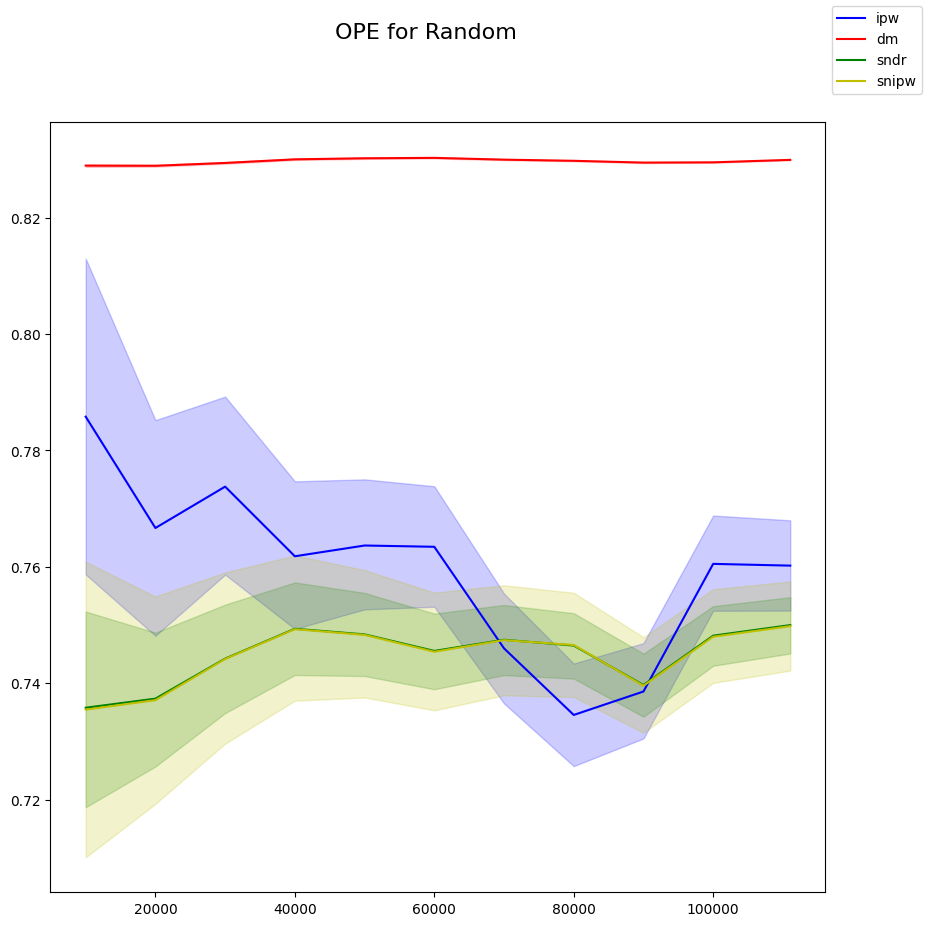

In [42]:
plot_join_res(Vs_3, CIs_3, 'Random')

In [40]:
test_pos_idx = np.where(bandit_feedback_test['reward'] == 1)[0]
test_actions_pos = bandit_feedback_test['action'][test_pos_idx]
test_context_pos = bandit_feedback_test['context'][test_pos_idx]

In [43]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 1))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 1))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 1))

Ucb


100%|██████████| 111/111 [00:37<00:00,  3.00it/s]                               


{'hr@1': 0.0, 'mrr@1': 0.0, 'ndcg@1': 0.0, 'cov@1': 0.09296935359258306}
Lin_ucb


100%|██████████| 111/111 [00:15<00:00,  7.18it/s]


{'hr@1': 0.0, 'mrr@1': 0.0, 'ndcg@1': 0.0, 'cov@1': 0.09116662374452743}
Random


100%|██████████| 111/111 [00:33<00:00,  3.27it/s]

{'hr@1': 0.0, 'mrr@1': 0.0, 'ndcg@1': 0.0, 'cov@1': 0.09142415657996394}


In [44]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 3))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 3))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 3))

Ucb


100%|██████████| 111/111 [00:33<00:00,  3.30it/s]


{'hr@3': 0.0, 'mrr@3': 0.0, 'ndcg@3': 0.0, 'cov@3': 0.3247489054854494}
Lin_ucb


100%|██████████| 111/111 [00:15<00:00,  7.23it/s]


{'hr@3': 0.0, 'mrr@3': 0.0, 'ndcg@3': 0.0, 'cov@3': 0.3319598248776719}
Random


100%|██████████| 111/111 [00:33<00:00,  3.33it/s]


{'hr@3': 0.0, 'mrr@3': 0.0, 'ndcg@3': 0.0, 'cov@3': 0.32268864280195725}


In [45]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 10))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 10))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 10))

Ucb


100%|██████████| 111/111 [00:34<00:00,  3.17it/s]


{'hr@10': 0.0036199095022624436, 'mrr@10': 0.0004927099044746104, 'ndcg@10': 0.0011787413540252612, 'cov@10': 0.5426216842647438}
Lin_ucb


100%|██████████| 111/111 [00:15<00:00,  7.16it/s]


{'hr@10': 0.0, 'mrr@10': 0.0, 'ndcg@10': 0.0, 'cov@10': 0.6126706155034767}
Random


100%|██████████| 111/111 [00:34<00:00,  3.23it/s]


{'hr@10': 0.006334841628959276, 'mrr@10': 0.001014149249443367, 'ndcg@10': 0.0022136152802388637, 'cov@10': 0.5858872006180788}


In [116]:
# ssh hdilab@172.21.136.110 -p 22